In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:77% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import re
import pickle
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import OrderedDict
from net.st_gcn import Model
from feeder.feeder import Feeder
from torchlight.io import IO
from ad_utils import map2ind, loader_initializer
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, precision=5, suppress=True)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Loading of original weights
data_dir_path = '/root/sharedfolder/datasets/data_ssd/kinetics-skeleton/st-gcn_kinetics/Kinetics/kinetics-skeleton/'
root_path = '/root/sharedfolder/Research/pose_ad/st-gcn/'
weights_path =  os.path.join(root_path, 'models/kinetics-st_gcn.pt')
ft_weights_path = os.path.join(root_path, 'models/kinetics-st_gcn_ft.pt')
io = IO(root_path)
model_name = 'net.st_gcn.Model'
graph_args = {'layout':'openpose', 'strategy':'spatial'}
model_args = {
    'edge_importance_weighting':True,
    'graph_args':graph_args,
    'in_channels':3,
    'num_class':4, }

In [4]:
model = io.load_model(model_name, **model_args)

In [5]:
# Need to turn into a func
weights = torch.load(weights_path)
weights_list = [[k.split('module.')[-1], v.cpu()] for k, v in weights.items()]
weights = OrderedDict(weights_list)
model_state_dict = model.state_dict()
weights.pop('fcn.bias') # loading all but the Final FC layer's weight and bias
weights.pop('fcn.weight')
model_state_dict.update(weights)
model.load_state_dict(model_state_dict)

In [6]:
# Freezing of layers for fine tuning
for name, param in model.named_parameters():
    param.requires_grad = False
    if "fcn" in name:  # Keeping the last FC layer trainable
        param.requires_grad = True
#     if name.find('9') != -1:  # For adding an additional graph conv layer to the training
#         param.requires_grad = True
    print (name, param.requires_grad) 

data_bn.weight False
data_bn.bias False
st_gcn_networks.0.gcn.conv.weight False
st_gcn_networks.0.gcn.conv.bias False
st_gcn_networks.0.tcn.0.weight False
st_gcn_networks.0.tcn.0.bias False
st_gcn_networks.0.tcn.2.weight False
st_gcn_networks.0.tcn.2.bias False
st_gcn_networks.0.tcn.3.weight False
st_gcn_networks.0.tcn.3.bias False
st_gcn_networks.1.gcn.conv.weight False
st_gcn_networks.1.gcn.conv.bias False
st_gcn_networks.1.tcn.0.weight False
st_gcn_networks.1.tcn.0.bias False
st_gcn_networks.1.tcn.2.weight False
st_gcn_networks.1.tcn.2.bias False
st_gcn_networks.1.tcn.3.weight False
st_gcn_networks.1.tcn.3.bias False
st_gcn_networks.2.gcn.conv.weight False
st_gcn_networks.2.gcn.conv.bias False
st_gcn_networks.2.tcn.0.weight False
st_gcn_networks.2.tcn.0.bias False
st_gcn_networks.2.tcn.2.weight False
st_gcn_networks.2.tcn.2.bias False
st_gcn_networks.2.tcn.3.weight False
st_gcn_networks.2.tcn.3.bias False
st_gcn_networks.3.gcn.conv.weight False
st_gcn_networks.3.gcn.conv.bias False


In [7]:
data_path   = dict()
label_path  = dict()
data_loader = dict()
feeder_args = dict()

In [81]:
train_data_path = os.path.join(data_dir_path, 'train_data.npy')
train_label_path = os.path.join(data_dir_path, 'train_label.pkl')
test_data_path = os.path.join(data_dir_path, 'val_data.npy')
test_label_path = os.path.join(data_dir_path, 'val_label.pkl')

# test_feeder_args = {'data_path': test_data_path, 'label_path': test_label_path}
# train_feeder_args = {'data_path': train_data_path, 'label_path': train_label_path}

In [8]:
normal_classes = [30, 74, 22, 15]
for split in ['normal_train', 'normal_test', 'mixed_test']:
    data_path[split]   =  os.path.join(data_dir_path, 'ad_experiment', split+'_data.npy')
    label_path[split]  =  os.path.join(data_dir_path, 'ad_experiment', split+'_label.pkl')
    feeder_args[split] = {'data_path': data_path[split], 'label_path': label_path[split]}
    
feeder_args['random_train'] = {'data_path': train_data_path, 'label_path': train_label_path, 'specify_classes':normal_classes}
feeder_args['random_test'] = {'data_path': train_data_path, 'label_path': train_label_path, 'specify_classes':normal_classes}

In [9]:
batch_size=32
data_loader['normal_train'] = loader_initializer(feeder_args['normal_train'], batch_size=batch_size)
data_loader['normal_test' ] = loader_initializer(feeder_args['normal_test' ], batch_size=batch_size, drop_last=False)
data_loader['mixed_test'  ] = loader_initializer(feeder_args['mixed_test'  ], batch_size=batch_size, suffle=False, drop_last=False)

In [10]:
# Model Definitions for Training
dev = 'cuda:0'
model = model.to(dev)
loss_fn = nn.CrossEntropyLoss()
loader = data_loader['normal_train']
loss_th = 0.15

In [11]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [12]:
# Training Loop
train = False

if train:
    for epoch in range(3):
        for itern, [data, label] in enumerate(loader):
                # get data
                data = data.float().to(dev)
                label = torch.from_numpy(map2ind(label))
                label = label.long().to(dev)

                # forward
                output = model(data)
                loss = loss_fn(output, label)

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if itern%10 == 0: 
                    print("Iteration {} (Epoch: {}), loss is {}".format(itern, epoch, loss))
                if loss < loss_th:
                    print("Met loss {} in Epoch {}, iteration {}".format(loss, epoch, itern))
                    break
        else:
            continue
        break
    print("Done")
if False:
    torch.save(model.state_dict(), ft_weights_path)

In [13]:
# For output evaluation
sfmax_vals, cls = torch.max(output, 1)
print("Correct predictions\n {}".format(cls==label))
softmax = nn.Softmax(dim=1)
osoftmax_gpu = softmax(output)

sfmax_vals, cls = torch.max(osoftmax_gpu, 1)

osoftmax = 100 * osoftmax_gpu.cpu().detach().numpy()
print("Softmax Outputs \n{} \nSofmax max values \n{}".format(osoftmax, sfmax_vals))
torch.mean(sfmax_vals)

NameError: name 'output' is not defined

In [14]:
dev = 'cuda:0'
model_ld = io.load_model(model_name, **model_args)
model_ld.load_state_dict(torch.load(ft_weights_path))
model_ld.to(dev)
model_ld.eval()

Model(
  (data_bn): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (st_gcn_networks): ModuleList(
    (0): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0, inplace)
      )
      (relu): ReLU(inplace)
    )
    (1): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4

In [32]:
# Model Definitions for Testing
loader = data_loader['mixed_test']
model = model_ld
loss_value = []
result_frag = []
label_frag = []
outputs = []
epoch_info = dict()
confusion_mat = np.zeros([5,5], dtype=np.int32)
evaluation = True
softmax = nn.Softmax(dim=1)

In [33]:
for itern, [data, label] in enumerate(loader):
    # get data
    print(data.shape)
    data = data.float().cuda()
    label_mapped = map2ind(label, from_arr=[59, 88, 134, 254], to_arr=None, def_val=0)
    label = torch.from_numpy(label_mapped)
    label = label.long().cuda()

    # inference
    with torch.no_grad():
        output = model(data)
    result_frag.append(output.data.cpu().numpy())

    # get loss
    if evaluation:
        loss = loss_fn(output, label)
        confusion_mat[label_mapped, np.argmax(output, axis=1)] += 1
        loss_value.append(loss.item())
        label_frag.append(label.data.cpu().numpy())
        outputs.append([itern ,softmax(output).data.cpu().numpy()])

result = np.concatenate(result_frag)
# np.savetxt("kinetics400_confusion.csv", confusion_mat)
if evaluation:
    label2 = np.concatenate(label_frag)
    epoch_info['mean_loss'] = np.mean(loss_value)

torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([32, 3, 300, 18, 2])
torch.Size([30, 3, 300, 18, 2])


In [56]:
len(outputs)
out_sfmax = [np.array(sf) for i, sf in outputs]
out_sfmax = np.concatenate(out_sfmax, axis=0)
out_sfmax_max_vals = out_sfmax.max(axis=1)
split_idx = 198
normal_max_sfmax = out_sfmax_max_vals[:split_idx]
abnormal_max_sfmax = out_sfmax_max_vals[split_idx:]
print(normal_max_sfmax.mean(), abnormal_max_sfmax.mean())

0.8414951 0.5924338


In [24]:
# For output evaluation
sfmax_vals, cls = torch.max(output, 1)
print("Correct predictions\n {}".format(cls==label))
softmax = nn.Softmax(dim=1)
osoftmax_gpu = softmax(output)

sfmax_vals, cls = torch.max(osoftmax_gpu, 1)

osoftmax = 100 * osoftmax_gpu.cpu().detach().numpy()
print("Softmax Outputs \n{} \nSofmax max values \n{}".format(osoftmax, sfmax_vals))
torch.mean(sfmax_vals)

Correct predictions
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.uint8)
Softmax Outputs 
[[ 2.38759  5.20045 70.42581 21.98615]
 [ 8.36586 29.51257 61.46564  0.65593]
 [11.35104 31.59918 56.79933  0.25046]
 [ 6.33818 20.43501 72.95511  0.2717 ]
 [ 8.35812 61.06318 29.97376  0.60494]
 [24.36323 37.54582 15.48518 22.60577]
 [22.42867 15.96951 61.32678  0.27504]
 [12.96688 21.66751 63.94969  1.41592]
 [13.37609 39.31338 47.09524  0.21529]
 [17.80134  4.89542 75.59003  1.7132 ]
 [ 3.57876 42.93718 52.99109  0.49297]
 [12.8463  66.03494 11.98808  9.13067]
 [14.22797 18.9969  66.46335  0.31178]
 [ 6.49656 12.19654 81.04906  0.25785]
 [ 5.17477  6.28993 84.54577  3.98953]
 [ 5.82527 67.57509 21.06733  5.53232]
 [44.60141 34.80457  9.69858 10.89543]
 [ 2.88564 15.39229 80.76624  0.95583]
 [34.07813 20.38449 35.18842 10.34897]
 [12.81423 47.49286 39.15441  0.53851]
 [20.93756 37.71311 19.37988 21.96946]


tensor(0.6111, device='cuda:0')

In [70]:
from sklearn.metrics import roc_curve, auc

true_labels = np.concatenate((np.ones_like(normal_max_sfmax), np.zeros_like(abnormal_max_sfmax)))
fpr, tpr, thresholds = roc_curve(true_labels, out_sfmax_max_vals)
roc_auc = auc(fpr, tpr)

roc_auc

0.8728076216712579

In [79]:
ind=95
print(tpr[ind], fpr[ind], thresholds[ind])

0.8333333333333334 0.21818181818181817 0.7131677


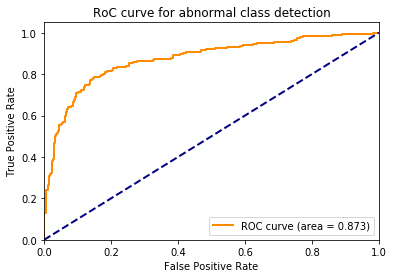

In [71]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoC curve for abnormal class detection')
plt.legend(loc="lower right")
plt.show()